# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [38]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-10-01,771,156,87,67,867,15,0.0,2.0,3.0,5,5.0
2020-10-02,789,163,66,50,883,11,0.0,0.0,2.0,6,3.0
2020-10-03,819,185,73,74,882,13,0.0,0.0,4.0,4,5.0
2020-10-04,866,186,86,34,934,14,0.0,0.0,1.0,5,8.0
2020-10-05,937,195,87,33,988,3,0.0,1.0,0.0,2,0.0


### Initialize the model without time-dependent parameters

In [4]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

In [5]:
model = models.COVID19_SEIRD(initial_states, params)

### Calibrating $\beta$ and lag_time

**Go to next section if posterior samples are available**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [6]:
# define dataset
data=[df_sciensano["H_in"].values[:11]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=100,popsize=200)

No constraints given.
Best after iteration 1: [6.39270326e+01 5.14349052e+01 3.71174555e-02] 50.93546100663877
Best after iteration 2: [6.39270326e+01 5.14349052e+01 3.71174555e-02] 50.93546100663877
New best for swarm at iteration 3: [4.92900289e+01 5.33028918e+01 3.67111316e-02] 48.89941024888889
Best after iteration 3: [4.92900289e+01 5.33028918e+01 3.67111316e-02] 48.89941024888889
Best after iteration 4: [4.92900289e+01 5.33028918e+01 3.67111316e-02] 48.89941024888889
Best after iteration 5: [4.92900289e+01 5.33028918e+01 3.67111316e-02] 48.89941024888889
Best after iteration 6: [4.92900289e+01 5.33028918e+01 3.67111316e-02] 48.89941024888889
New best for swarm at iteration 7: [6.03158319e+01 5.35652626e+01 3.60365060e-02] 48.58860502429886
Best after iteration 7: [6.03158319e+01 5.35652626e+01 3.60365060e-02] 48.58860502429886
New best for swarm at iteration 8: [4.80306867e+01 5.61036473e+01 3.47663084e-02] 47.792489955527515
Best after iteration 8: [4.80306867e+01 5.61036473e+01

Best after iteration 70: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
Best after iteration 71: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
Best after iteration 72: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
Best after iteration 73: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
Best after iteration 74: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
Best after iteration 75: [4.60420104e+01 5.76097989e+01 3.38508121e-02] 47.62572038201124
New best for swarm at iteration 76: [4.60435368e+01 5.76075197e+01 3.38508304e-02] 47.62572031636117
Best after iteration 76: [4.60435368e+01 5.76075197e+01 3.38508304e-02] 47.62572031636117
Best after iteration 77: [4.60435368e+01 5.76075197e+01 3.38508304e-02] 47.62572031636117
Best after iteration 78: [4.60435368e+01 5.76075197e+01 3.38508304e-02] 47.62572031636117
Best after iteration 79: [4.60435368e+01 5.76075197e+01 3.38508304e-02] 47.62572031636117

In [7]:
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))
# Date of first data collection
start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))
# Initialise starting position of sampler based on PSO estimate
pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [15:56<00:00, 10.45it/s]


In [9]:
samples = sampler.get_chain(discard=500,flat=False)
flat_samples = sampler.get_chain(discard=500,flat=True)

In [10]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

[51.67659516 37.17580544]


In [11]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 1 = beta
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

0.033833905526546304 0.03359926050362943 0.03405871769490815


Initialize a dictionary with the posterior samples and write them to `parameters_deterministic.json`

In [12]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [13]:
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make a traceplot and cornerplot of the posterior samples

<AxesSubplot:xlabel='step number', ylabel='beta'>

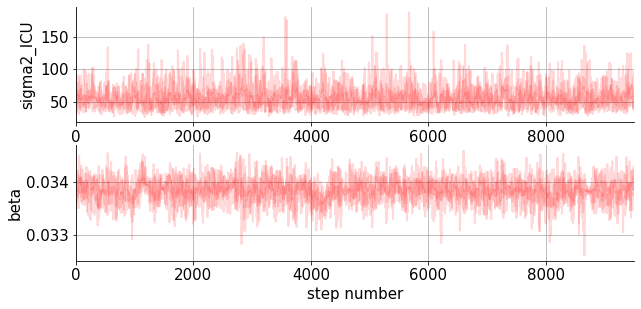

In [14]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-15-0958ef6f598c>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',


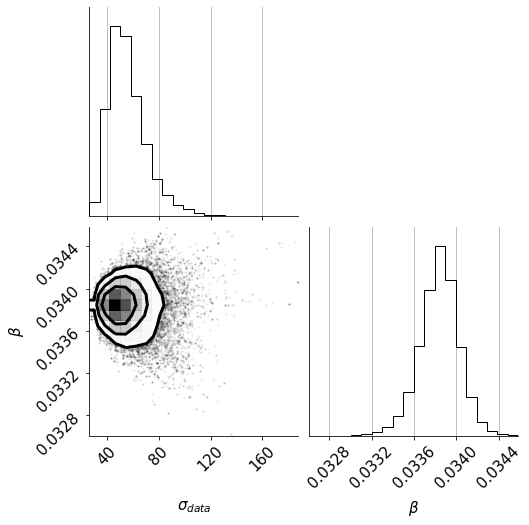

In [15]:
fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

Make a visualisation of the data and model prediction

<ipython-input-16-e52a7922fb6f>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


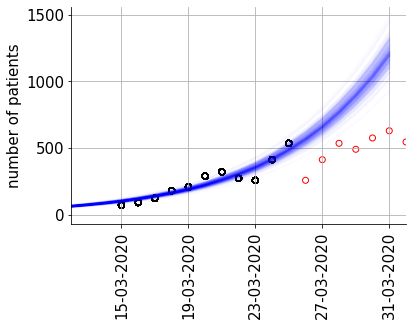

In [16]:
T = 6
fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.02})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance ramp parameters

In [18]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

Define the social policy change + two parameter ramp compliance

In [19]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [20]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

Update the parameter dictionary

In [21]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

Initialize the model

In [22]:
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

Load the previously calibrated parameters.

In [23]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [24]:
samples_beta = {'beta': samples_dict['beta']}

Find an initial guess for the MCMC sampler by using PSO

In [25]:
# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,200),(0.1,20),(0.1,20),(0,0.8)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=samples_beta,maxiter=100,popsize=200)

No constraints given.
Best after iteration 1: [66.93336343 11.55028031  3.29316142  0.1617353 ] 177.3216679621527
Best after iteration 2: [66.93336343 11.55028031  3.29316142  0.1617353 ] 177.3216679621527
Best after iteration 3: [66.93336343 11.55028031  3.29316142  0.1617353 ] 177.3216679621527
New best for swarm at iteration 4: [89.68813389 14.66928362  0.1         0.34036117] 176.08585954095622
Best after iteration 4: [89.68813389 14.66928362  0.1         0.34036117] 176.08585954095622
New best for swarm at iteration 5: [65.44111702 12.14849408  0.1         0.44781132] 175.8009232833697
Best after iteration 5: [65.44111702 12.14849408  0.1         0.44781132] 175.8009232833697
New best for swarm at iteration 6: [86.49608118  8.79752171  2.7645026   0.38464292] 174.52489000911197
Best after iteration 6: [86.49608118  8.79752171  2.7645026   0.38464292] 174.52489000911197
New best for swarm at iteration 7: [58.72307123  4.49807298  5.08212159  0.38450139] 171.23556792548538
Best afte

Best after iteration 66: [54.48611316  0.78141829  7.00120008  0.3966504 ] 166.4628317522572
Best after iteration 67: [54.48611316  0.78141829  7.00120008  0.3966504 ] 166.4628317522572
New best for swarm at iteration 68: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 68: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 69: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 70: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 71: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 72: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 73: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 74: [54.31982415  0.80822368  6.99643213  0.39716155] 166.4611909940549
Best after iteration 75: [54.31982415  0.80822368  6.996432

In [26]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2],
    'prevention': theta[3]
}
)

Initialize and run the MCMC sampler

In [27]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.01, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,samples_beta))
sampler.run_mcmc(pos, 12000, progress=True);

100%|██████████| 12000/12000 [48:59<00:00,  4.08it/s]


In [28]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

[61.15697162 75.3592098  77.00504344 62.35322003]


In [29]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

Append posterior samples to the samples dictionary

In [30]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [31]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [32]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 0 --> sigma_{data}
# index 3 --> prevention
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

3.581583854197724 0.5758002270045699 7.338183114546756


<AxesSubplot:xlabel='step number', ylabel='prevention'>

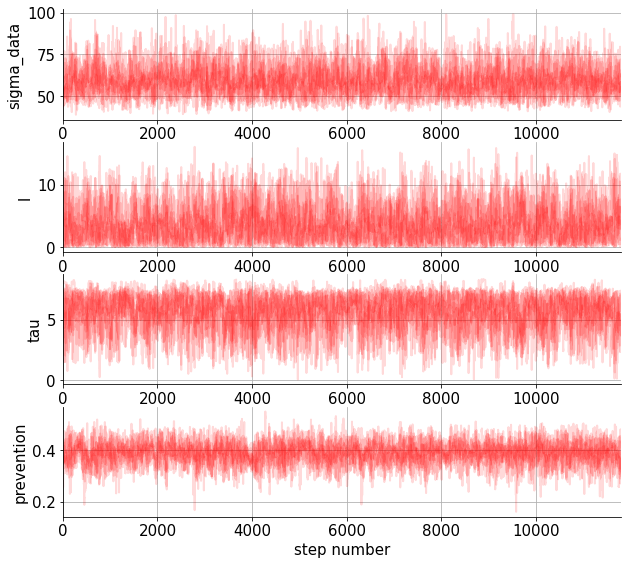

In [33]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-34-e758e7af66bd>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',


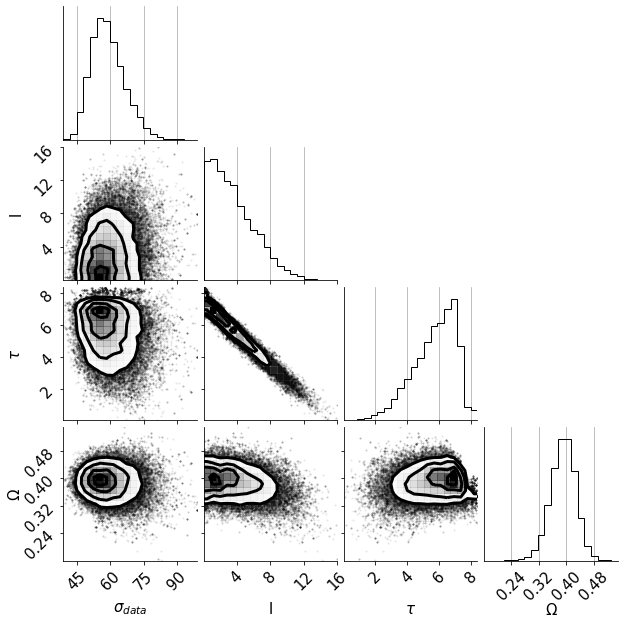

In [34]:
fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [40]:
MC_out = model.sim(100,N=100,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(100):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.04})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Computation of the basic reproduction number

In [ ]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

In [ ]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

### Visualisations used in the preprint

Load the posterior samples

In [7]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

#### Cumulative hospitalizations

TypeError: integrate() takes 35 positional arguments but 38 were given

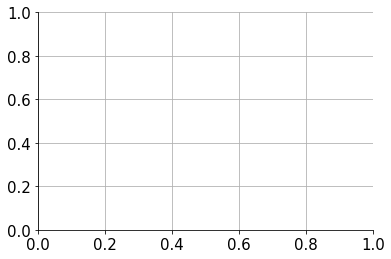

In [8]:
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)): 
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[samples_dict['lag_time']:-T],np.cumsum(data[i]),color="black",facecolors='none')
    
    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[samples_dict['lag_time']-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('../results/calibration_non_spatial_deterministic/hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Continuation of lockdown

In [9]:
data=[df_sciensano["H_tot"].values,df_sciensano["ICU_tot"].values]
states = [["H_tot"],["ICU"]]

In [24]:
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods = data[0].size + samples_dict['lag_time'] + 500)
print(index[1])
print(index[50])
print(index[52])
print(index[57])
print(index[64])
print(index[81])
print(index[108])
print(index[170])
print(index[232])
print(index[239])
print(index[281])
print(index[292])
print(index[337])
print(index[343])

2020-03-16 00:00:00
2020-05-04 00:00:00
2020-05-06 00:00:00
2020-05-11 00:00:00
2020-05-18 00:00:00
2020-06-04 00:00:00
2020-07-01 00:00:00
2020-09-01 00:00:00
2020-11-02 00:00:00
2020-11-09 00:00:00
2020-12-21 00:00:00
2021-01-01 00:00:00
2021-02-15 00:00:00
2021-02-21 00:00:00


<ipython-input-41-13d1ed244d11>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


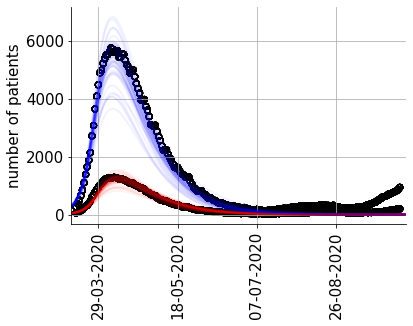

In [41]:
T = 3

fig,ax=plt.subplots()

for i in range(50):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
plt.savefig('../results/calibration_non_spatial_deterministic/continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Lockdown release

In [42]:
def lockdown_release_func(t,param,policy_time,policy1,policy2,policy3,policy4,policy5,policy6,policy7,policy8,policy9,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    elif policy_time + tau + l < t <= policy_time + 50: 
        return prevention*policy2
    elif policy_time + 50 < t <= policy_time + 52:
        return prevention*policy3
    elif policy_time + 52 < t <= policy_time + 57:
        return prevention*policy4
    elif policy_time + 57 < t <= policy_time + 64:
        return prevention*policy5
    elif policy_time + 64 < t <= policy_time + 81:
        return prevention*policy6
    elif policy_time + 81 < t <= policy_time + 108:
        return prevention*policy7
    elif policy_time + 108 < t <= policy_time + 170:
        return prevention*policy8
    else:
        return prevention*policy9

In [43]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
               'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

In [44]:
model_lr = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_release_func})

<ipython-input-45-7fbe876e1433>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


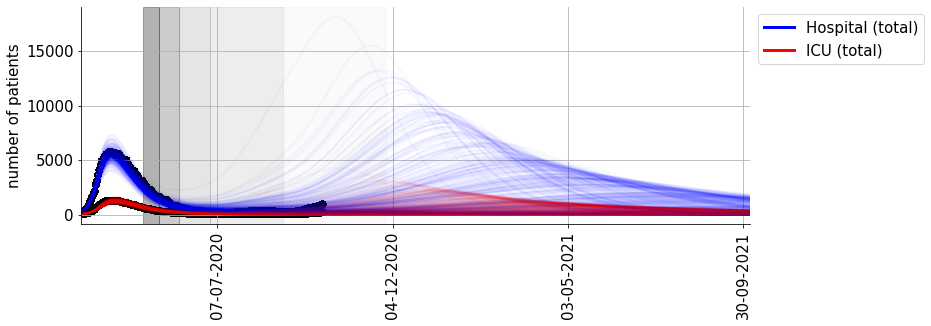

In [45]:
T = 365

fig,ax=plt.subplots()
fig.set_size_inches(12, 4)

ax.axvspan(index[50], index[64], alpha=0.30, color='black') # 11 mei
ax.axvspan(index[64], index[81], alpha=0.20, color='black') # 1 juni
ax.axvspan(index[81], index[108], alpha=0.10, color='black') # 1 juli
ax.axvspan(index[108], index[170], alpha=0.05, color='black') # 1 sept
ax.axvspan(index[108], index[-1], alpha=0.02, color='black') # 1 sept

for i in range(300):
    model_lr.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model_lr.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model_lr.parameters['tau'] = samples_dict['tau'][idx]
    model_lr.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model_lr.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.03})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.savefig('../results/calibration_non_spatial_deterministic/lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Seroprelevance

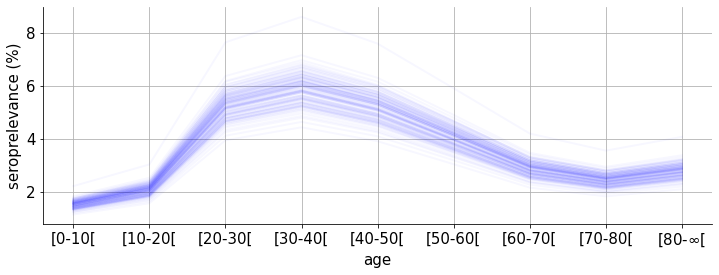

In [46]:
fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax.plot((1-y_model["S"][:,samples_dict['lag_time']+36]/y_model["S"][:,0])*100,alpha=0.03,color='blue',linewidth=2)
ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)

#### Basic reproduction number vs expected hospitalisations

1.6395334651043612 1.622569369942288 1.6555066290368379
2.231686147168368 2.2085951051260917 2.253428361910102
4.327023302724359 4.2822520085493725 4.369179351396208
5.005183161504858 4.953395012459683 5.053946186385048
4.133041226457599 4.090277046179073 4.173307403668986
3.0096566671317704 2.9785160389024217 3.0389782640053715
1.6483013621245532 1.6312465463748325 1.6643599473426747
0.9498446157347445 0.9400166648002504 0.9590984822037317
0.7997196090523636 0.7914449871311352 0.807510881806041


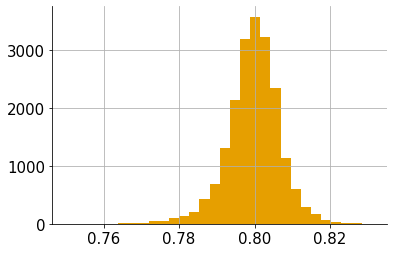

In [47]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

means=np.zeros(R_0.shape[0])
for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    means[i]=mean
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

In [48]:
# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

n=100
csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])

    # ages i plus
    data2plot = y_model[states[0]].to_array(dim="states").values.ravel()
    val = y_model[states[0]].to_array(dim="states").values[-1,:,:].sum(axis=1)
    #csum_iplus=np.cumsum(val)
    csum_iplus=val
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    #csum_save[i,:] = csum_iplus/csum_iplus[-1]
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)

<ipython-input-49-0dc83a1cfc8b>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


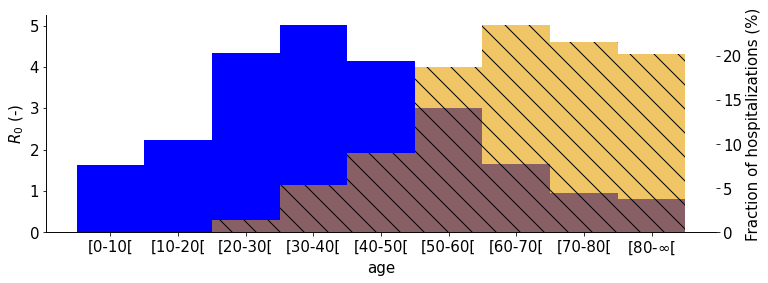

In [49]:
fig,ax1=plt.subplots()

ax1.bar(np.arange(R_0.shape[0]),means,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(R_0.shape[0]),csum_hosp_mean,1,alpha=0.6,hatch="\\")
ax2.set_xlabel('age')
ax2.set_ylabel('Fraction of hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)
plt.savefig('../results/calibration_non_spatial_deterministic/R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

### Re-estimating beta

In [50]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [51]:
def beta_reestimate_func(t,param,change_beta_time,beta_old,beta_new):
    if t <= change_beta_time:
        return beta_old
    elif change_beta_time < t <= change_beta_time+120:
        return beta_new
    else:
        return beta_new

In [52]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

In [53]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Add all time-dependent parameters to function definition
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
               'change_beta_time': np.mean(samples_dict['lag_time'])+50,
               'beta_old': np.mean(samples_dict['beta']),
               'beta_new': 0.06})
# Initialise the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func, 'beta': beta_reestimate_func})

In [54]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

In [55]:
T = 62
from copy import deepcopy
# define dataset
data=[df_sciensano["H_in"].values[:]]
# Redine lag_time
model.extraTime = samples_dict['lag_time']
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta_new'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.06)) # must be a list!

In [56]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=smpls,maxiter=50,popsize=20)

No constraints given.
New best for swarm at iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
Best after iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
New best for swarm at iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 3: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 4: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 5: [5.72996498e+01 1.00000000e-03] 891.4818397745754
New best for swarm at iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
Best after iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
New best for swarm at iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 8: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 9: [5.42044761e+01 1.00000000

In [57]:
parNames = ['sigma_ICU','beta_new'] # must be a list!
bounds=((1,200),(0.0001,0.20))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,smpls))
sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


In [58]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [59]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [60]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.06035435457147051 0.05706839312423164 0.06325335615126233


In [61]:
samples_dict.update({'beta_new': flat_samples[:,1].tolist()})

In [62]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

<AxesSubplot:xlabel='step number', ylabel='beta_new'>

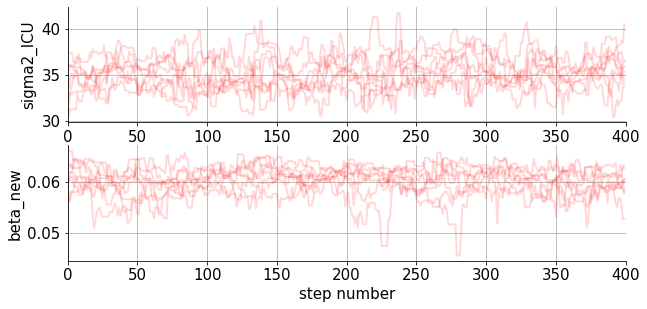

In [63]:
traceplot(samples,labels=["sigma2_ICU","beta_new"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-64-3a2dc3afe2ca>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',


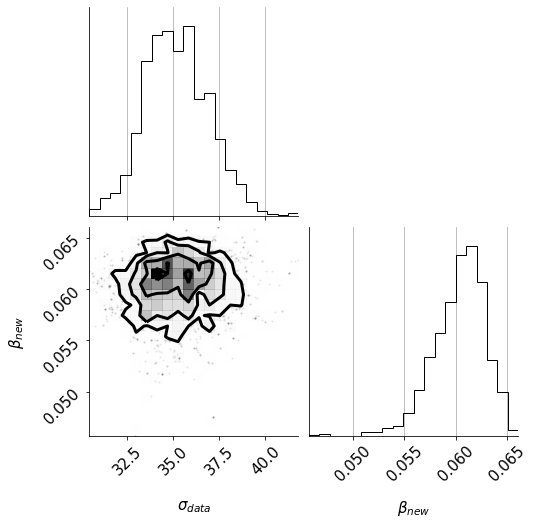

In [64]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta_{new}$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [65]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

<ipython-input-66-df54aaea604f>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


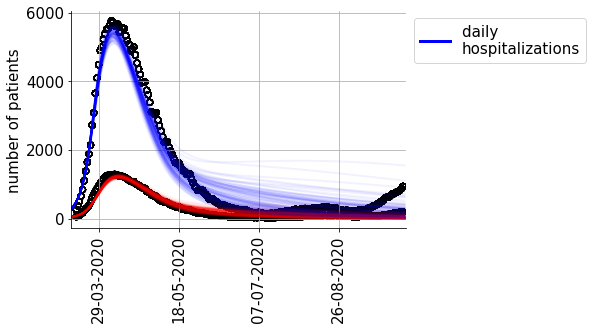

In [66]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    model.parameters['beta_new'] = np.random.choice(samples_dict['beta_new'],1,replace=False)

    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [67]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)